<img src="image-20240915-151830.png" width="" align="" />

### Import

In [ ]:
import pandas as pd
import numpy as np
import mglearn
import matplotlib.pyplot as plt
import scipy

import itertools
from scipy.stats import loguniform

from mlxtend.classifier import Adaline

from sklearn.preprocessing import MinMaxScaler, OneHotEncoder, LabelEncoder
from sklearn.impute import SimpleImputer

from sklearn.model_selection import RandomizedSearchCV, RepeatedStratifiedKFold, cross_validate
from sklearn.model_selection import train_test_split, cross_val_score, cross_val_predict, KFold, StratifiedKFold, RepeatedKFold, ShuffleSplit, StratifiedShuffleSplit, learning_curve, validation_curve

from sklearn.compose import ColumnTransformer

from sklearn.decomposition import PCA

from imblearn.pipeline import Pipeline as IMBPipeline

import imblearn
from imblearn.over_sampling import RandomOverSampler, SMOTE
from imblearn.under_sampling import RandomUnderSampler


from sklearn.pipeline import Pipeline

from sklearn.metrics import precision_score, accuracy_score, recall_score
from sklearn.metrics import f1_score, confusion_matrix
from sklearn.metrics import ConfusionMatrixDisplay
from sklearn.metrics import silhouette_score, silhouette_samples, normalized_mutual_info_score


from sklearn.discriminant_analysis import LinearDiscriminantAnalysis as LDA

from sklearn.neighbors import KNeighborsClassifier

from sklearn.linear_model import Perceptron, LogisticRegression

from mlxtend.feature_selection import SequentialFeatureSelector as SFS
from mlxtend.plotting import plot_decision_regions

from sklearn.svm import LinearSVC, SVC

from sklearn.tree import DecisionTreeClassifier, DecisionTreeRegressor
from sklearn import tree, datasets

from sklearn.manifold import TSNE

from sklearn.cluster import KMeans, AgglomerativeClustering, DBSCAN

from sklearn.ensemble import VotingClassifier, BaggingClassifier, RandomForestClassifier, RandomForestRegressor, AdaBoostClassifier

import warnings
#warnings.filterwarnings("ignore", category=ConvergenceWarning)

warnings.filterwarnings("ignore", category=FutureWarning)

# Fish Classification

### Problem

This project involves a classification problem where the goal is to identify different species of fish from a dataset. 

The dataset contains various features related to the fish, and the task is to build a model that can  classify the fish into one of several classes. 

Let's have a quick overview of the data:

In [ ]:
fish = pd.read_excel('fish_classification_dataset.xlsx')

In [ ]:
fish

,Length,Weight,Water Type,Habitat,Diet,Coloration,Fish Type
0,122,188,Saltwater,River,Omnivore,Red,Tuna
1,290,407,Freshwater,Reef,Carnivore,Spotted,Catfish
2,126,430,Freshwater,Open Ocean,Carnivore,Blue,Catfish
3,91,308,Saltwater,River,Herbivore,Green,Tuna
4,208,138,Saltwater,Lake,Omnivore,Spotted,Tuna
...,...,...,...,...,...,...,...
9995,74,332,Freshwater,Lake,Omnivore,Striped,Trout
9996,228,326,Freshwater,Lake,Carnivore,Silver,Bass
9997,36,252,Saltwater,Open Ocean,Omnivore,Yellow,Tuna
9998,87,394,Saltwater,Open Ocean,Carnivore,Silver,Tuna


The dataset provided contains detailed information about various fish species, capturing several key attributes that are crucial for classification and analysis. 

Each record in the dataset includes the following features:

Length: The length of the fish in centimeters.

Weight: The weight of the fish in grams.

Water Type: The type of water environment where the fish is found, such as Saltwater or Freshwater.

Habitat: The specific habitat within the water type, such as River, Reef, or Open Ocean.

Diet: The feeding habits of the fish, classified into categories like Omnivore, Carnivore, or Herbivore.

Coloration: The color or pattern of the fish, which can help in visual identification.

Fish Type: The species of the fish, such as Tuna, Catfish, or Snapper.

The diverse features and species represented in this dataset offer a rich foundation for classification tasks, pattern recognition, and exploratory data analysis. 

By leveraging these attributes, it is possible to build models to predict fish types based on environmental and biological factors, potentially enhancing our understanding of aquatic biodiversity and aiding in ecological studies.

### Introduce noise

Since my dataset is "artificial" (generated randomly) it does not include noise.

For the purpose of the project, I am going to introduce some.

In [ ]:
missing_rate = 0.1  # 10% missing values

for col in fish.columns[:-1]:
    missing_indices = np.random.choice(fish.index, size=int(missing_rate * len(fish)), replace=False)
    fish.loc[missing_indices, col] = np.nan

Let's get back analyzing our dataset:

In [ ]:
fish.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10000 entries, 0 to 9999
Data columns (total 7 columns):
 #   Column      Non-Null Count  Dtype  
---  ------      --------------  -----  
 0   Length      9000 non-null   float64
 1   Weight      9000 non-null   float64
 2   Water Type  9000 non-null   object 
 3   Habitat     9000 non-null   object 
 4   Diet        9000 non-null   object 
 5   Coloration  9000 non-null   object 
 6   Fish Type   10000 non-null  object 
dtypes: float64(2), object(5)
memory usage: 547.0+ KB


We can see that the dataset has 10000 collected samples and 6 features.

The features of the dataset are:

In [ ]:
fish_samples = fish.drop(columns=[fish.columns[-1]])
print("Keys of fish dataset:\n", fish_samples.keys())

Keys of fish dataset:
 Index(['Length', 'Weight', 'Water Type', 'Habitat', 'Diet', 'Coloration'], dtype='object')


While the target names (the classes to be predicted) are:

In [ ]:
fish_target = fish['Fish Type']
target_names = fish_target.unique()

print('Target names:',target_names)

Target names: ['Tuna' 'Catfish' 'Snapper' 'Trout' 'Swordfish' 'Bass' 'Shark' 'Goldfish'
 'Salmon' 'Clownfish']


We can also have a look at the balance of the data. 

In this case, we will see that we have much more samples for Tuna, or Catfish, and very few for Goldfish, Salmon, Clownfish.

For this reason, later we will have to perform a resampling.

In fact:

In [ ]:
print("Sample counts per class:\n", fish['Fish Type'].value_counts())

Sample counts per class:
 Fish Type
Tuna         3878
Catfish      2568
Snapper      1133
Trout         973
Swordfish     574
Bass          480
Shark         295
Goldfish       58
Salmon         26
Clownfish      15
Name: count, dtype: int64


Let's see the dimension of the dataset:

In [ ]:
print("Shape of data:", fish_samples.shape)
print("Shape of target", fish_target.shape)

Shape of data: (10000, 6)
Shape of target (10000,)


Let's check the null-values:

In [ ]:
print('Null-values in the features\n', fish_samples.isnull().sum(axis=0))
print('Null-values in the target', fish_target.isnull().sum(axis=0))

Null-values in the features
 Length        1000
Weight        1000
Water Type    1000
Habitat       1000
Diet          1000
Coloration    1000
dtype: int64
Null-values in the target 0


# Splitting into train and test

First thing to do, is splitting the dataset into training and testing data.

I use stratify = y to keep to reflect the distribution of the target class.

test_size means that I keep the 20% of the data in my test set and the 80% in the train set.

random_state = 42 so that I can always keep the same partition if I re-run the program.

In [ ]:
X =fish_samples
y = fish_target

X_train, X_test, y_train, y_test = train_test_split(X, y, 
    stratify = y, 
    test_size=0.2, 
    random_state=42
)

To be sure, we check the dimensions of the two new dataset:

In [ ]:
print("X_train shape:", X_train.shape)
print("y_train shape:", y_train.shape)
print("X_test shape:", X_test.shape)
print("y_test shape:", y_test.shape)

X_train shape: (8000, 6)
y_train shape: (8000,)
X_test shape: (2000, 6)
y_test shape: (2000,)


We can also check if the stratification worked:

In [ ]:
print("| Fish Type    | Train Set (%) | Test Set (%) |")
print("+--------------+---------------+--------------+")

for fish_type in target_names:
    train_percentage = (sum(y_train == fish_type)/len(y_train)) * 100
    test_percentage = (sum(y_test == fish_type)/len(y_test)) * 100
    print(f"| {fish_type:<12} | {train_percentage:^12.2f}% | {test_percentage:^11.2f}% |")



print("+--------------+---------------+--------------+")

| Fish Type    | Train Set (%) | Test Set (%) |
+--------------+---------------+--------------+
| Tuna         |    38.77    % |    38.80   % |
| Catfish      |    25.67    % |    25.70   % |
| Snapper      |    11.33    % |    11.35   % |
| Trout        |     9.74    % |    9.70    % |
| Swordfish    |     5.74    % |    5.75    % |
| Bass         |     4.80    % |    4.80    % |
| Shark        |     2.95    % |    2.95    % |
| Goldfish     |     0.59    % |    0.55    % |
| Salmon       |     0.26    % |    0.25    % |
| Clownfish    |     0.15    % |    0.15    % |
+--------------+---------------+--------------+


We can check:

In [ ]:
X_train.head(), X_test.head()

(      Length  Weight  Water Type     Habitat       Diet Coloration
 1580   195.0     NaN   Saltwater  Open Ocean  Carnivore      Green
 3152   200.0   368.0   Saltwater       River  Carnivore     Silver
 2913    43.0   214.0   Saltwater       River  Herbivore        NaN
 5438    88.0     NaN  Freshwater        Lake  Carnivore        Red
 5424    70.0    62.0   Saltwater        Reef   Omnivore     Yellow,
       Length  Weight  Water Type     Habitat       Diet Coloration
 2288    59.0     NaN         NaN        Lake  Herbivore        Red
 6273    51.0   357.0  Freshwater        Reef        NaN        Red
 8135   232.0   113.0   Saltwater        Lake   Omnivore     Silver
 9968   186.0   176.0   Saltwater        Reef        NaN    Spotted
 7281   125.0    40.0   Saltwater  Open Ocean  Herbivore       Blue)

In [ ]:
y_train.head(), y_test.head()

(1580      Shark
 3152       Tuna
 2913       Tuna
 5438       Bass
 5424    Snapper
 Name: Fish Type, dtype: object,
 2288         Tuna
 6273      Catfish
 8135         Tuna
 9968      Snapper
 7281    Swordfish
 Name: Fish Type, dtype: object)

In [ ]:
# i will use this later to create the sampling strategy
class_counts = pd.Series(y_train).value_counts()
print("Class distribution:\n", class_counts)

Class distribution:
 Fish Type
Tuna         3102
Catfish      2054
Snapper       906
Trout         779
Swordfish     459
Bass          384
Shark         236
Goldfish       47
Salmon         21
Clownfish      12
Name: count, dtype: int64


# Transforming data

Looking at my data, I want to transform my values in such a way that the classifier can deal better with them.

First, I deal with my missing values.

To fix them, I use a SimpleImputer with strategy = 'median' for my numerical data and strategy = 'most_frequent' for me categorical data.

The length, weight columns are numerical. I want to apply a MinMaxScaler so that all my values are going to be transformed in a value between 0 and 1.

I prefer a MinMaxScaler over a StandardScaler because I do not expect a Gaussian distribution in my data.

The WaterType, Habitat, Diet, Coloration columns are nominal. They cannot be ordered, so I use a OneHotEncoder.

<img src="image-20240912-181605.png" width="" align="" />

I use drop = 'first' because I don't need to have the first column, after the ONeHotEncoder transformation, since it does not add any information.

categories = 'auto' because I don't need to have particular classes, I can let the algorithm assume the categories by itself.

verbose_feature_names_out = False because I don't need to have the name of the columns specified.

In [ ]:
fish_transformer = ColumnTransformer(
    transformers=[
        ('length', Pipeline([
            ('imputer', SimpleImputer(strategy='mean')),
            ('scaler', MinMaxScaler())
        ]), ['Length']),
        
        ('weight', Pipeline([
            ('imputer', SimpleImputer(strategy='mean')),
            ('scaler', MinMaxScaler())
        ]), ['Weight']),
        
        ('water type', Pipeline([
            ('imputer', SimpleImputer(strategy='most_frequent')),  
            ('encoder', OneHotEncoder(drop='first', categories='auto'))
        ]), ['Water Type']),
        
        ('habitat', Pipeline([
            ('imputer', SimpleImputer(strategy='most_frequent')), 
            ('encoder', OneHotEncoder(drop='first', categories='auto'))
        ]), ['Habitat']),
        
        ('diet', Pipeline([
            ('imputer', SimpleImputer(strategy='most_frequent')),
            ('encoder', OneHotEncoder(drop='first', categories='auto'))
        ]), ['Diet']),
        
        ('coloration', Pipeline([
            ('imputer', SimpleImputer(strategy='most_frequent')), 
            ('encoder', OneHotEncoder(drop='first', categories='auto'))
        ]), ['Coloration'])
    ],
    verbose_feature_names_out=False
)


I also need to transform the labels (y):

I use LabelEncoder so that every target name is assigned to a number. 

I fit the transformer on the y_train set, and then I apply it also to the y_test, in order to avoid something  like: (Shark -> 2) in the train set and (Shark -> 1) in the test set.

In [ ]:
label_encoder = LabelEncoder()

y_train_transformed = label_encoder.fit_transform(y_train)
y_test_transformed = label_encoder.transform(y_test)

But I want to remember how my original labels are mapped, so I check:

In [ ]:
for label, code in zip(label_encoder.classes_, label_encoder.transform(label_encoder.classes_)):
    print(f"{label}: {code}")

Bass: 0
Catfish: 1
Clownfish: 2
Goldfish: 3
Salmon: 4
Shark: 5
Snapper: 6
Swordfish: 7
Trout: 8
Tuna: 9


# Create a Pipeline

First, I want to understand my sampling_strategy that I will use in my model, since I am dealing with very unbalanced data.

In [ ]:
sampling_strategy = {
    0: 800,   # Bass
    1: 2054,  # Catfish
    2: 100    # Clownfish
    3: 200,   # Goldfish
    4: 100,   # Salmon
    5: 800,   # Shark
    6: 1000,  # Snapper
    7: 800,   # Swordfish
    8: 1000,  # Trout
    9: 3102,  # Tuna
}

Now I create my starting Pipeline:

In [ ]:
model_pipeline = IMBPipeline([
    ('trans', fish_transformer),
    ('sampler', SMOTE(k_neighbors=3, sampling_strategy=sampling_strategy)),
    ('dim_reduction', PCA()),
    ('classifier', Perceptron())
])

Let's fit it with my training set, so that the model can learn how to make the predictions.

In [ ]:
model_pipeline.fit(X_train,y_train_transformed)

Pipeline(steps=[('trans',
                 ColumnTransformer(transformers=[('length',
                                                  Pipeline(steps=[('imputer',
                                                                   SimpleImputer()),
                                                                  ('scaler',
                                                                   MinMaxScaler())]),
                                                  ['Length']),
                                                 ('weight',
                                                  Pipeline(steps=[('imputer',
                                                                   SimpleImputer()),
                                                                  ('scaler',
                                                                   MinMaxScaler())]),
                                                  ['Weight']),
                                                 ('water type',
                                                  Pipeline(steps=[('imputer',
                                                                   SimpleImputer(strategy='most_frequent')),
                                                                  ('encoder',
                                                                   OneHotEncoder...
                                                  ['Diet']),
                                                 ('coloration',
                                                  Pipeline(steps=[('imputer',
                                                                   SimpleImputer(strategy='most_frequent')),
                                                                  ('encoder',
                                                                   OneHotEncoder(drop='first'))]),
                                                  ['Coloration'])],
                                   verbose_feature_names_out=False)),
                ('sampler',
                 SMOTE(k_neighbors=3,
                       sampling_strategy={0: 800, 1: 2054, 2: 100, 3: 200,
                                          4: 100, 5: 800, 6: 1000, 7: 800,
                                          8: 1000, 9: 3102})),
                ('dim_reduction', PCA()), ('classifier', Perceptron())])

# Create the configurations

Let's create some configurations that will define different sets of hyperparameters for sampling, classification, and dimensionality reduction.

In [ ]:
sampler_configs = [
    {
        'sampler':[SMOTE(k_neighbors = 4, n_jobs=-1)],
        'sampler__sampling_strategy':[sampling_strategy]
    },
    {
        'sampler':[RandomOverSampler()],
        'sampler__sampling_strategy':[sampling_strategy]
    }
]

With SMOTE (Synthetic Minority Over-sampling Technique) I create synthetic samples for the minority classes to balance the dataset.

k_neighbors=4: Uses 4 nearest neighbors to generate synthetic samples.
n_jobs=-1: Uses all available cores to parallelize the computation.

RandomOverSampler: Randomly duplicates samples from the minority class to achieve balance.

For both SMOTE and RandomOverSampler, I use my customsampling_strategy that I specified before.

In [ ]:
classifier_configs = [
    {
        'classifier__eta0' : loguniform(0.001,100),   #ok
        'classifier': [Perceptron()] ,
        'classifier__max_iter': [100,200] ,
        'classifier__class_weight' : [None, 'balanced']

    },
    {
        'classifier': [KNeighborsClassifier()],  #ok
        'classifier__n_neighbors': [3,5,9]
    },
    {
        'classifier' : [RandomForestClassifier()], # ok
        'classifier__n_estimators' : [10,50,100],
        'classifier__max_depth' : [5, 10]
    },
#    {
#        'classifier' : [SVC(kernel = 'poly')],  # ok, troppo lungo
#        'classifier__degree' : [2,3],
#        'classifier__coef0' : [0.1, 0.5, 1],
#        'classifier__C' : [0.001, 0.01, 0.1, 1, 10, 100],

#    },
    {
        'classifier' : [RandomForestClassifier()],  # ok
        'classifier__n_estimators' : [10, 50, 100],
        'classifier__max_depth' : [5, 10, 15],
    },
    {
        'classifier' : [DecisionTreeClassifier(criterion='gini', random_state=42)],  # ok
        'classifier__max_depth' : [5, 10]

    },

]

For my classifiers, I will use 

- Perceptron

Parameters: eta0 (learning rate. I used a loguniform to cover a wide range), max_iter (number of iterations for training), class_weight (to handle class imbalances);

- KNeighborsClassifier

Parameters: n_neighbors to define the number of neighbors to be considered;

- RandomForestClassifier

Parameters: n_estimators (number of trees in the forest), max_depth (maximum depth of the trees);

- DecisionTreeClassifier

Parameters: criterion (here: Gini. For splitting), max_depth (maximum depth of the tree).

In [ ]:
dim_reduction_configs = [
    {
        'dim_reduction': [None]
    },
    {
        'dim_reduction': [PCA()],
        'dim_reduction__n_components': [0.5, 0.7]
    },
    {
        'dim_reduction': [LDA()]
    },
    {
        'dim_reduction': [SFS(estimator = Perceptron(), scoring = 'f1_macro')],
        'dim_reduction__k_features' : [6, 10]  # note: my onehotencoder will create 15 features  
    }
]

I will try differen options for the dimensionality reduction:

- None

No dimensionality reduction is applied.

- PCA (Principal Component Analysis)

Parameters: n_components (the proportion of variance to retain)

- LDA (Linear Discriminant Analysis)

- SFS (Sequential Feature Selector)

Parameters: estimator (the model used to evaluate feature subsets), scoring (metric used to evaluate the performance), k_features (number of features to select)

Now, we can build a list of all the possible configurations (combination of sampler, classifier, dim reduction with respective parameters).

The goal is to find the best one.

In [ ]:
all_configs = [dict(itertools.chain(*(e.items() 
for e in configuration))) 
for configuration in 
itertools.product(sampler_configs,dim_reduction_configs,classifier_configs)]

We can check the first two to see if it worked:

In [ ]:
f'Number of all possible configurations: {len(all_configs)}'

'Number of all possible configurations: 40'

Check the first two:

In [ ]:
all_configs[:2]

[{'sampler': [SMOTE(k_neighbors=4, n_jobs=-1)],
  'sampler__sampling_strategy': [{9: 3102,
    1: 2054,
    6: 1000,
    8: 1000,
    7: 800,
    0: 800,
    5: 800,
    3: 200,
    4: 100,
    2: 100}],
  'dim_reduction': [None],
  'classifier__eta0': <scipy.stats._distn_infrastructure.rv_continuous_frozen at 0x7f17f0888c70>,
  'classifier': [Perceptron()],
  'classifier__max_iter': [100, 200],
  'classifier__class_weight': [None, 'balanced']},
 {'sampler': [SMOTE(k_neighbors=4, n_jobs=-1)],
  'sampler__sampling_strategy': [{9: 3102,
    1: 2054,
    6: 1000,
    8: 1000,
    7: 800,
    0: 800,
    5: 800,
    3: 200,
    4: 100,
    2: 100}],
  'dim_reduction': [None],
  'classifier': [KNeighborsClassifier()],
  'classifier__n_neighbors': [3, 5, 9]}]

## Identify the best 3 models

Now, I want to identify 3 best models.

To do that, I apply a randomized grid search between all the configurations that I got before. The search takes a list of all the configurations, does a 3-cross validation and gets the score as f1_macro, since I am dealing with umbalanced classes.

For every search, I identify the best model. Total: 3 models.

In [ ]:
cv_strategy = StratifiedKFold(n_splits=3)

With StratifiedKFold, I divide the dataset in 3 and keep the same proportion of each class as the original dataset (importnat, since my classes are very umbalanced).

In [ ]:
rs = RandomizedSearchCV(model_pipeline,
    param_distributions=all_configs,
    n_iter=len(all_configs),
    n_jobs=-1,
    cv = cv_strategy,
    scoring='f1_macro'
)

n_iter=len(all_configs) means that all the possible configurations will be analyzed (so it's going to be similar to a normal grid search).

cv cross validation is going to be my cv_strategy.

These are going to be the results for my 3 fold evaluation:

In [ ]:
scores = cross_validate(rs, X_train, y_train_transformed, scoring='f1_macro', cv = cv_strategy, return_estimator=True, verbose=3) #29 min

[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[CV] END ......................................., score=0.651 total time=10.8min
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed: 10.8min remaining:    0.0s
[CV] END ......................................., score=0.712 total time=10.5min
[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed: 21.3min remaining:    0.0s
[CV] END ......................................., score=0.792 total time= 7.7min
[Parallel(n_jobs=1)]: Done   3 out of   3 | elapsed: 29.0min finished


I can also check their performance: (of the best classifier for each fold).

In [ ]:
for index, estimator in enumerate(scores['estimator']):
    print('classifier:', estimator.best_estimator_.get_params()['classifier'])
    print(estimator.best_estimator_.get_params()['classifier'].get_params())
    print(' ')
    print('sampler:', estimator.best_estimator_.get_params()['sampler'])
    print('dim_reduction:', estimator.best_estimator_.get_params()['dim_reduction'])
    print(scores['test_score'][index])
    print('-'*10)

classifier: RandomForestClassifier(max_depth=5, n_estimators=50)
{'bootstrap': True, 'ccp_alpha': 0.0, 'class_weight': None, 'criterion': 'gini', 'max_depth': 5, 'max_features': 'sqrt', 'max_leaf_nodes': None, 'max_samples': None, 'min_impurity_decrease': 0.0, 'min_samples_leaf': 1, 'min_samples_split': 2, 'min_weight_fraction_leaf': 0.0, 'n_estimators': 50, 'n_jobs': None, 'oob_score': False, 'random_state': None, 'verbose': 0, 'warm_start': False}
 
sampler: SMOTE(k_neighbors=4, n_jobs=-1,
      sampling_strategy={0: 800, 1: 2054, 2: 100, 3: 200, 4: 100, 5: 800,
                         6: 1000, 7: 800, 8: 1000, 9: 3102})
dim_reduction: SequentialFeatureSelector(estimator=Perceptron(), k_features=(10, 10),
                          scoring='f1_macro')
0.6508667553762095
----------
classifier: DecisionTreeClassifier(max_depth=5, random_state=42)
{'ccp_alpha': 0.0, 'class_weight': None, 'criterion': 'gini', 'max_depth': 5, 'max_features': None, 'max_leaf_nodes': None, 'min_impurity_dec

In [ ]:
results = []

for i, estimator in enumerate(scores['estimator']):
    estimator.best_estimator_.fit(X_train, y_train_transformed)
    y_pred_train = estimator.best_estimator_.predict(X_train)
    y_pred_test = estimator.best_estimator_.predict(X_test)
    f1_train = f1_score(y_train_transformed, y_pred_train, average='macro')
    f1_test = f1_score(y_test_transformed, y_pred_test, average='macro')

    results.append((i + 1, f1_train, f1_test))

print("+-------+------------------------+------------------------+")
print("| Fold  | F1 Score (Training Set) | F1 Score (Test Set)    |")
print("+-------+------------------------+------------------------+")
for fold, f1_train, f1_test in results:
    print(f"| {fold:<5} | {f1_train:<22.2f} | {f1_test:<22.2f} |")
print("+-------+------------------------+------------------------+")

+-------+------------------------+------------------------+
| Fold  | F1 Score (Training Set) | F1 Score (Test Set)    |
+-------+------------------------+------------------------+
| 1     | 0.76                   | 0.71                   |
| 2     | 0.78                   | 0.76                   |
| 3     | 0.86                   | 0.80                   |
+-------+------------------------+------------------------+


The best model achieved a F1-macro score of approximately 0.86 for the training set and 0.80 for the testing set, demonstrating a good overall performance across all classes. 

This model, a RandomForestClassifier with a maximum depth of 10 and 50 estimators, effectively balances complexity and performance. 

The use of SMOTE with a well-defined sampling strategy addresses class imbalance, ensuring that the model is robust across underrepresented classes. 

With no dimensionality reduction applied, the model leverages the full feature set, optimizing its classification capability. 

# Improve the best model

Sp, I create a default pipeline for the model:

In [ ]:
best_model_pipeline = IMBPipeline([
    ('trans', fish_transformer),
    ('dim_reduction', None),
    ('sampler', SMOTE(k_neighbors=4, n_jobs=-1, sampling_strategy=sampling_strategy)),
    ('classifier',RandomForestClassifier(random_state=42, bootstrap=True)),
])

Now it's time to improve this model  by exploring the neighbourhood of the hyperparameters.

We define a new randomized search.

In [ ]:
params = {  
    'classifier__max_depth': [None, 10, 20, 30],   
    'classifier__max_features': [1, 3, 5],
    'classifier__n_estimators': [50, 100, 200],   
}

In [ ]:
rs_best = RandomizedSearchCV(
    estimator = best_model_pipeline,
    param_distributions = params,
    cv = RepeatedStratifiedKFold(n_splits=5, n_repeats=3),
    n_iter=36,
    scoring='f1_macro'
)

I chose n_iter36 because the total number of combinations of parameters is 36 (4*3*3). This way I can explore all the combinations to find the best performance.

Now, I will fit the pipeline, which includes data transformation, sampling, and classification, on each training fold, and predictions will be made on the corresponding validation fold.

The performance of each combination is evaluated using the f1_macro scoring metric, and the results are averaged across the folds to get a final score for each parameter set.

After evaluating all sampled combinations, RandomizedSearchCV identifies the parameter combination that achieved the highest f1_macro score.
This best combination is then used to refit the model on the entire training dataset.

The results of the search, including the best parameters, best score, and the performance of all tested combinations, are stored in the rs_best object.

In [ ]:
rs_best.fit(X_train, y_train_transformed)  # 8 min

RandomizedSearchCV(cv=RepeatedStratifiedKFold(n_repeats=3, n_splits=5, random_state=None),
                   estimator=Pipeline(steps=[('trans',
                                              ColumnTransformer(transformers=[('length',
                                                                               Pipeline(steps=[('imputer',
                                                                                                SimpleImputer()),
                                                                                               ('scaler',
                                                                                                MinMaxScaler())]),
                                                                               ['Length']),
                                                                              ('weight',
                                                                               Pipeline(steps=[('imputer',
                                                                                                SimpleImputer()),
                                                                                               ('scaler',
                                                                                                MinMaxScaler())]),
                                                                               ['Weight']),
                                                                              ('water...
                                             ('sampler',
                                              SMOTE(k_neighbors=4, n_jobs=-1,
                                                    sampling_strategy={0: 800,
                                                                       1: 2054,
                                                                       2: 100,
                                                                       3: 200,
                                                                       4: 100,
                                                                       5: 800,
                                                                       6: 1000,
                                                                       7: 800,
                                                                       8: 1000,
                                                                       9: 3102})),
                                             ('classifier',
                                              RandomForestClassifier(random_state=42))]),
                   n_iter=36,
                   param_distributions={'classifier__max_depth': [None, 10, 20,
                                                                  30],
                                        'classifier__max_features': [1, 3, 5],
                                        'classifier__n_estimators': [50, 100,
                                                                     200]},
                   scoring='f1_macro')

rs_best.best_estimator_ provides the Pipeline that has been trained with the best parameters:

In [ ]:
rs_best.best_estimator_

Pipeline(steps=[('trans',
                 ColumnTransformer(transformers=[('length',
                                                  Pipeline(steps=[('imputer',
                                                                   SimpleImputer()),
                                                                  ('scaler',
                                                                   MinMaxScaler())]),
                                                  ['Length']),
                                                 ('weight',
                                                  Pipeline(steps=[('imputer',
                                                                   SimpleImputer()),
                                                                  ('scaler',
                                                                   MinMaxScaler())]),
                                                  ['Weight']),
                                                 ('water type',
                                                  Pipeline(steps=[('imputer',
                                                                   SimpleImputer(strategy='most_frequent')),
                                                                  ('encoder',
                                                                   OneHotEncoder...
                                                                   SimpleImputer(strategy='most_frequent')),
                                                                  ('encoder',
                                                                   OneHotEncoder(drop='first'))]),
                                                  ['Coloration'])],
                                   verbose_feature_names_out=False)),
                ('dim_reduction', None),
                ('sampler',
                 SMOTE(k_neighbors=4, n_jobs=-1,
                       sampling_strategy={0: 800, 1: 2054, 2: 100, 3: 200,
                                          4: 100, 5: 800, 6: 1000, 7: 800,
                                          8: 1000, 9: 3102})),
                ('classifier',
                 RandomForestClassifier(max_depth=10, max_features=5,
                                        n_estimators=200, random_state=42))])

We can also compute the f1_score on the test test to check to assess how well our final model generalizes.

In [ ]:
f1_score(y_test_transformed, rs_best.best_estimator_.predict(X_test), average = 'macro')

0.8433527777514765

# Learning curve and training curve

We now want to visualize training and learning curves, since they are key tools for evaluating model performance:

### Learning Curve

It plots performance on both training and validation data as training progresses. 

We can use it to check overfitting or underfitting.

In [ ]:
train_sizes, train_scores, test_scores = learning_curve(rs_best.best_estimator_,
                                                       X=X_train,
                                                       y=y_train_transformed,
                                                       train_sizes= [0.01, 0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9, 1.0],
                                                       cv = 5,
                                                       n_jobs = -1,
                                                       scoring = 'f1_macro',
                                                       shuffle = False)

train_sizes is going to show different sizes of the training set taken in consideration.

train_scores is going to be the score for each portion of the training set, and test_scores for the validation set of each portion of training set.

(0.6, 1.03)

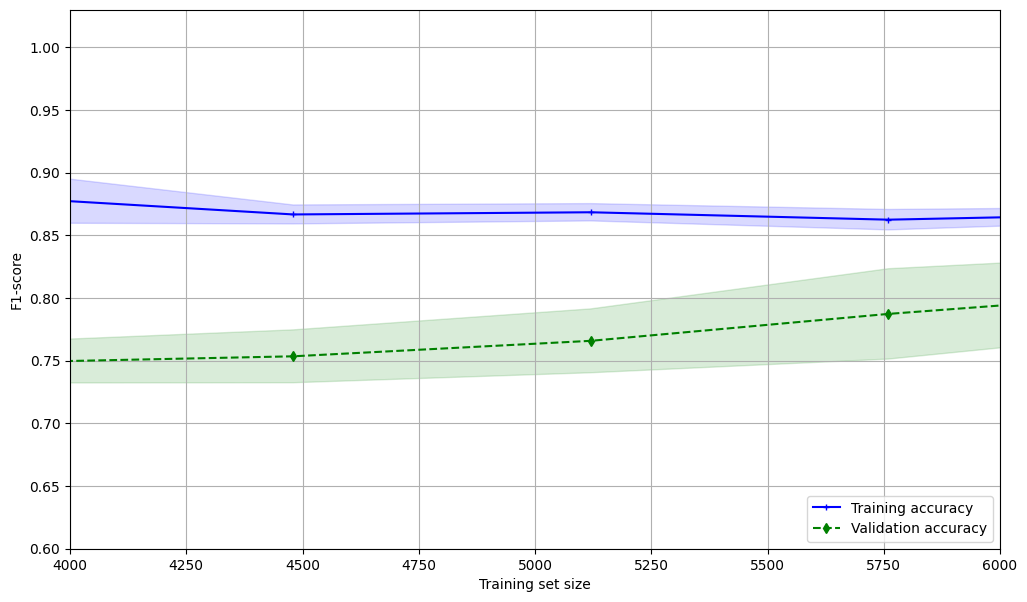

In [ ]:
train_mean = np.mean(train_scores, axis=1)
train_std = np.std(train_scores, axis=1)
test_mean = np.mean(test_scores, axis=1)
test_std = np.std(test_scores, axis=1)

fig=plt.figure(figsize=(12,7))
ax = fig.add_subplot()

ax.plot(train_sizes, train_mean,
         color='blue', marker='+',
         markersize=5, label='Training accuracy')

ax.fill_between(train_sizes,
                 train_mean + train_std,
                 train_mean - train_std,
                 alpha=0.15, color='blue')

ax.plot(train_sizes, test_mean,
         color='green', linestyle='--',
         marker='d', markersize=5,
         label='Validation accuracy')

ax.fill_between(train_sizes,
                 test_mean + test_std,
                 test_mean - test_std,
                 alpha=0.15, color='green')

ax.grid()
ax.set_xlabel('Training set size')
ax.set_ylabel('F1-score')
ax.legend(loc='lower right')
ax.set_xlim([4000,6000])
ax.set_ylim([0.60, 1.03])

The blue line represents the model's performance on the training set, and the shaded area around it is the confidence interval (standard deviation).

Initially, the F1-score is around 0.90, and it shows a slight decline as the training set size increases.

This decrease indicates that as more data is added, the model is becoming less overfitted and more generalized with more training data.

The green dashed line represents the model's performance on the validation set, with the shaded area indicating variability.

The F1-score on the validation set starts around 0.75 and steadily improves as the training set size increases.

This upward trend in validation F1-score is a sign of generalization, indicating that as the model is trained on more data, it performs better on unseen data.

The validation F1-score approaches the training F1-score but does not exceed it. This is typical and suggests that the model is not overfitting but is approaching its generalization limits.

The F1-score improvement on the validation set suggests that adding more training data may continue to improve model performance.

In summary, this graph suggests that our model is learning well from the training data, and as we increase the amount of training data, its performance on unseen validation data is improving.

### Validation Curve

The validation curve provides insights about how changes in the max_depth, max_features and max_ estimators parameters affect both training and validation performance. 

By plotting these scores, we can visually compare the training accuracy and validation accuracy. 

This helps in identifying the optimal depth / features / estimators that balance model complexity and generalization, guiding us toward a more effective model configuration.

The curves represent the F1-score and the shaded areas around the curves represent the standard deviation.

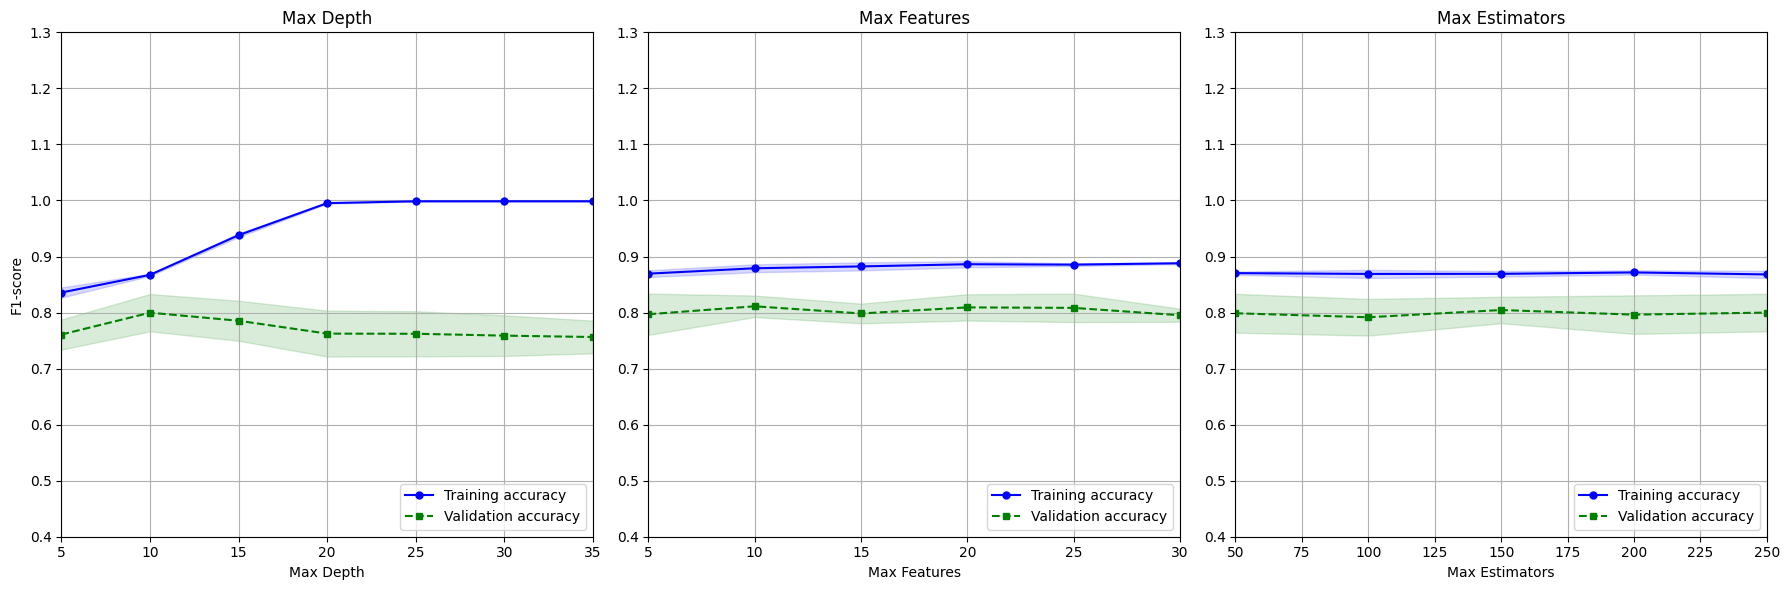

In [ ]:
range_depth = [5, 10, 15, 20, 25, 30, 35]
range_features = [5, 10, 15, 20, 25, 30]
range_estimators = [50, 100, 150, 200, 250]

# validation curves for max_depth
train_scores_depth, test_scores_depth = validation_curve(
    rs_best.best_estimator_,
    X=X_train,
    y=y_train_transformed,
    param_range=range_depth,
    param_name='classifier__max_depth',
    cv=5,
    n_jobs=-1,
    scoring='f1_macro'
)
train_mean_depth = np.mean(train_scores_depth, axis=1)
train_std_depth = np.std(train_scores_depth, axis=1)
test_mean_depth = np.mean(test_scores_depth, axis=1)
test_std_depth = np.std(test_scores_depth, axis=1)

# validation curves for max_features
train_scores_features, test_scores_features = validation_curve(
    rs_best.best_estimator_,
    X=X_train,
    y=y_train_transformed,
    param_range=range_features,
    param_name='classifier__max_features',
    cv=5,
    n_jobs=-1,
    scoring='f1_macro'
)
train_mean_features = np.mean(train_scores_features, axis=1)
train_std_features = np.std(train_scores_features, axis=1)
test_mean_features = np.mean(test_scores_features, axis=1)
test_std_features = np.std(test_scores_features, axis=1)

# validation curves for max_estimators
train_scores_estimators, test_scores_estimators = validation_curve(
    rs_best.best_estimator_,
    X=X_train,
    y=y_train_transformed,
    param_range=range_estimators,
    param_name='classifier__n_estimators',
    cv=5,
    n_jobs=-1,
    scoring='f1_macro'
)
train_mean_estimators = np.mean(train_scores_estimators, axis=1)
train_std_estimators = np.std(train_scores_estimators, axis=1)
test_mean_estimators = np.mean(test_scores_estimators, axis=1)
test_std_estimators = np.std(test_scores_estimators, axis=1)


fig, axs = plt.subplots(1, 3, figsize=(18, 6))

# plot for max_depth
axs[0].plot(range_depth, train_mean_depth, color='blue', marker='o', markersize=5, label='Training accuracy')
axs[0].fill_between(range_depth, train_mean_depth + train_std_depth, train_mean_depth - train_std_depth, alpha=0.15, color='blue')
axs[0].plot(range_depth, test_mean_depth, color='green', linestyle='--', marker='s', markersize=5, label='Validation accuracy')
axs[0].fill_between(range_depth, test_mean_depth + test_std_depth, test_mean_depth - test_std_depth, alpha=0.15, color='green')
axs[0].set_xlabel('Max Depth')
axs[0].set_ylabel('F1-score')
axs[0].set_ylim([0.4, 1.3])
axs[0].set_xlim([min(range_depth), max(range_depth)])
axs[0].grid()
axs[0].legend(loc='lower right')
axs[0].set_title('Max Depth')

# plot for max_features
axs[1].plot(range_features, train_mean_features, color='blue', marker='o', markersize=5, label='Training accuracy')
axs[1].fill_between(range_features, train_mean_features + train_std_features, train_mean_features - train_std_features, alpha=0.15, color='blue')
axs[1].plot(range_features, test_mean_features, color='green', linestyle='--', marker='s', markersize=5, label='Validation accuracy')
axs[1].fill_between(range_features, test_mean_features + test_std_features, test_mean_features - test_std_features, alpha=0.15, color='green')
axs[1].set_xlabel('Max Features')
axs[1].set_ylim([0.4, 1.3])
axs[1].set_xlim([min(range_features), max(range_features)])
axs[1].grid()
axs[1].legend(loc='lower right')
axs[1].set_title('Max Features')

# plot for max_estimators
axs[2].plot(range_estimators, train_mean_estimators, color='blue', marker='o', markersize=5, label='Training accuracy')
axs[2].fill_between(range_estimators, train_mean_estimators + train_std_estimators, train_mean_estimators - train_std_estimators, alpha=0.15, color='blue')
axs[2].plot(range_estimators, test_mean_estimators, color='green', linestyle='--', marker='s', markersize=5, label='Validation accuracy')
axs[2].fill_between(range_estimators, test_mean_estimators + test_std_estimators, test_mean_estimators - test_std_estimators, alpha=0.15, color='green')
axs[2].set_xlabel('Max Estimators')
axs[2].set_ylim([0.4, 1.3])
axs[2].set_xlim([min(range_estimators), max(range_estimators)])
axs[2].grid()
axs[2].legend(loc='lower right')
axs[2].set_title('Max Estimators')

plt.tight_layout()
plt.show()

- Max depth: increasing the max depth initially improves the model's performance, but eventually leads to overfitting. This is evident in the decrease in validation accuracy and F1-score beyond a certain depth.

- Max features: increasing the number of features used at each split also improves performance up to a point, but can lead to overfitting if too many features are used.

- Max estimators: increasing the number of estimators generally improves performance, as it helps to reduce the variance of the model. However, here, adding more estimators does not significantly improve the results.

<a style='text-decoration:none;line-height:16px;display:flex;color:#5B5B62;padding:10px;justify-content:end;' href='https://deepnote.com?utm_source=created-in-deepnote-cell&projectId=d1c78d89-6ec7-469d-838f-00c7cf4991d6' target="_blank">
 </img>
Created in <span style='font-weight:600;margin-left:4px;'>Deepnote</span></a>